In [ ]:
remove_zero_hotttnesss = 1

In [ ]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-w1dwkhy5
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-w1dwkhy5
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0062448419e5bdc1c58090591fc84a033c68c07e0_-cp36-none-any.whl size=145891 sha256=c0aa7b9ab86d2a863f89f8de8a975843aa5dc52ad59e18b5adc779b55c794a34
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkml5zsm/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


**Column names and sample display**

In [ ]:
# dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path = 'output copy.csv'
column_names = ['artist_name','title','artist_location,artsit_latitude', 'artist_longitude', 'release','artist_hotttness','familiarity'
,'danceability','duration','energy','loudness','year','tempo','analysis_rate','end_of_fade_in','key','key_confidence','mode','mode_confidence'
,'start_of_fade_out','time_signature','time_signature_conf', 'song_hotttness']
dataset = pd.read_csv(dataset_path)

dataset.head()

,artist_name,title,artist_location,artsit_latitude,artist_longitude,release,artist_hotttness,familiarity,danceability,duration,energy,loudness,year,tempo,analysis_rate,end_of_fade_in,key,key_confidence,mode,mode_confidence,start_of_fade_out,time_signature,time_signature_conf,song_hotttness
0,Raphaël,Je Sais Que La Terre Est Plate,France,1.71819,46.71067,Je Sais Que La Terre Est Plate Deluxe,0.386152,0.557460,0.0,148.74077,0.0,-9.636,2008,124.059,22050,0.192,0,0.591,1,0.556,141.607,4,0.372,0.547953
1,Julie Zenatti,On Efface,NaN,NaN,NaN,Comme Vous,0.434860,0.626958,0.0,252.99546,0.0,-11.061,2004,80.084,22050,0.514,1,0.429,0,0.670,241.424,4,0.533,0.475638
2,The Baltimore Consort,Howells Delight,NaN,NaN,NaN,Watkins Ale Music of the English Renaissance,0.000000,0.425724,0.0,78.02730,0.0,-24.140,0,54.874,22050,0.974,3,0.000,1,0.000,78.027,4,0.000,NaN
3,I Hate Sally,Martha Served,NaN,NaN,NaN,Dont Worry Lady,0.334520,0.611495,0.0,163.63057,0.0,-5.795,2007,77.150,22050,0.000,7,0.380,1,0.385,158.511,3,0.369,NaN
4,Orlando Pops Orchestra,ZipADeeDooDah Song of the South,NaN,NaN,NaN,Easy Listening Cartoon Songs,0.311616,0.367255,0.0,199.99302,0.0,-16.477,0,120.382,22050,0.000,10,0.551,1,0.528,195.808,4,1.000,NaN


**Drop non-numerical features**

In [ ]:
# drop non-numerical features 
col_name = list(dataset)
print('##### column names --> ',col_name)
to_drop = col_name[:6]
print('##### dropping --> ',to_drop)
dataset.drop(to_drop, inplace = True, axis = 1)
col_name = list(dataset)
print('{} samples before cleaning'.format(dataset.shape[0]))


##### column names -->  ['artist_name', 'title', 'artist_location', 'artsit_latitude', ' artist_longitude', ' release', 'artist_hotttness', 'familiarity', 'danceability', 'duration', 'energy', 'loudness', 'year', 'tempo', 'analysis_rate', 'end_of_fade_in', 'key', 'key_confidence', 'mode', 'mode_confidence', 'start_of_fade_out', 'time_signature', 'time_signature_conf', ' song_hotttness']
##### dropping -->  ['artist_name', 'title', 'artist_location', 'artsit_latitude', ' artist_longitude', ' release']
10000 samples before cleaning


**Clean data, remove data with (any) invalid features (e.g., nan for label)**

In [ ]:
# clean the data, removing those with invalid feature values (e.g., nan for label)
to_drop = set()

for index, row in dataset.iterrows():
    for col in col_name:
      if np.isnan(row[col]): to_drop.add(index)
      if remove_zero_hotttnesss == 1:
        if col == ' song_hotttness' and row[col] == 0: to_drop.add(index)

dataset.drop(to_drop, inplace = True, axis = 0)
dataset.head()
print('{} samples after cleaning'.format(dataset.shape[0]))
dataset.head()


4214 samples after cleaning


,artist_hotttness,familiarity,danceability,duration,energy,loudness,year,tempo,analysis_rate,end_of_fade_in,key,key_confidence,mode,mode_confidence,start_of_fade_out,time_signature,time_signature_conf,song_hotttness
0,0.386152,0.557460,0.0,148.74077,0.0,-9.636,2008,124.059,22050,0.192,0,0.591,1,0.556,141.607,4,0.372,0.547953
1,0.434860,0.626958,0.0,252.99546,0.0,-11.061,2004,80.084,22050,0.514,1,0.429,0,0.670,241.424,4,0.533,0.475638
5,0.363676,0.601306,0.0,279.35302,0.0,-12.474,0,99.024,22050,0.433,9,0.519,1,0.491,261.288,4,1.000,0.445455
6,0.553566,0.709011,0.0,255.03302,0.0,-4.393,0,175.673,22050,0.449,9,0.447,1,0.247,251.275,4,0.000,0.327737
8,0.539245,0.737038,0.0,216.84200,0.0,-4.264,1982,92.897,22050,0.000,10,0.325,1,0.286,213.020,4,0.879,0.788388


**Split into test and train data**

In [ ]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index,)

**Basic stats of training data**

In [ ]:
target = ' song_hotttness'
train_stats = train_dataset.describe()
train_stats.pop(target)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
artist_hotttness,3371.0,0.433917,0.117741,0.0000,0.364266,0.416936,0.497711,1.082503
familiarity,3371.0,0.623089,0.141757,0.0000,0.534392,0.618297,0.713322,0.989939
danceability,3371.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
duration,3371.0,241.334407,102.885745,27.0624,185.847710,229.668120,279.875465,1686.752200
energy,3371.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
loudness,3371.0,-9.570893,5.029934,-38.5250,-11.961500,-8.473000,-6.010000,0.566000
year,3371.0,1285.967962,957.486298,0.0000,0.000000,1993.000000,2004.000000,2010.000000
tempo,3371.0,124.381462,34.703966,0.0000,97.413000,121.667000,146.631000,258.677000
analysis_rate,3371.0,22050.000000,0.000000,22050.0000,22050.000000,22050.000000,22050.000000,22050.000000
end_of_fade_in,3371.0,0.754743,1.834807,0.0000,0.000000,0.184000,0.403000,32.972000


It became clear that 'danceability', 'energy', 'analysis_rate' should bear no weights in further analysis due to zero variance and should be removed as well.

In [ ]:
zero_var = ['danceability', 'energy', 'analysis_rate']
train_dataset.drop(zero_var, inplace = True, axis = 1)
test_dataset.drop(zero_var, inplace = True, axis = 1)
col_name = [i for i in col_name if i not in zero_var]

**Redo stats**

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop(target)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
artist_hotttness,3371.0,0.433917,0.117741,0.0000,0.364266,0.416936,0.497711,1.082503
familiarity,3371.0,0.623089,0.141757,0.0000,0.534392,0.618297,0.713322,0.989939
duration,3371.0,241.334407,102.885745,27.0624,185.847710,229.668120,279.875465,1686.752200
loudness,3371.0,-9.570893,5.029934,-38.5250,-11.961500,-8.473000,-6.010000,0.566000
year,3371.0,1285.967962,957.486298,0.0000,0.000000,1993.000000,2004.000000,2010.000000
tempo,3371.0,124.381462,34.703966,0.0000,97.413000,121.667000,146.631000,258.677000
end_of_fade_in,3371.0,0.754743,1.834807,0.0000,0.000000,0.184000,0.403000,32.972000
key,3371.0,5.294571,3.502203,0.0000,2.000000,5.000000,8.000000,11.000000
key_confidence,3371.0,0.454159,0.275811,0.0000,0.233000,0.482000,0.666000,1.000000
mode,3371.0,0.685257,0.464482,0.0000,0.000000,1.000000,1.000000,1.000000


**Visualization**

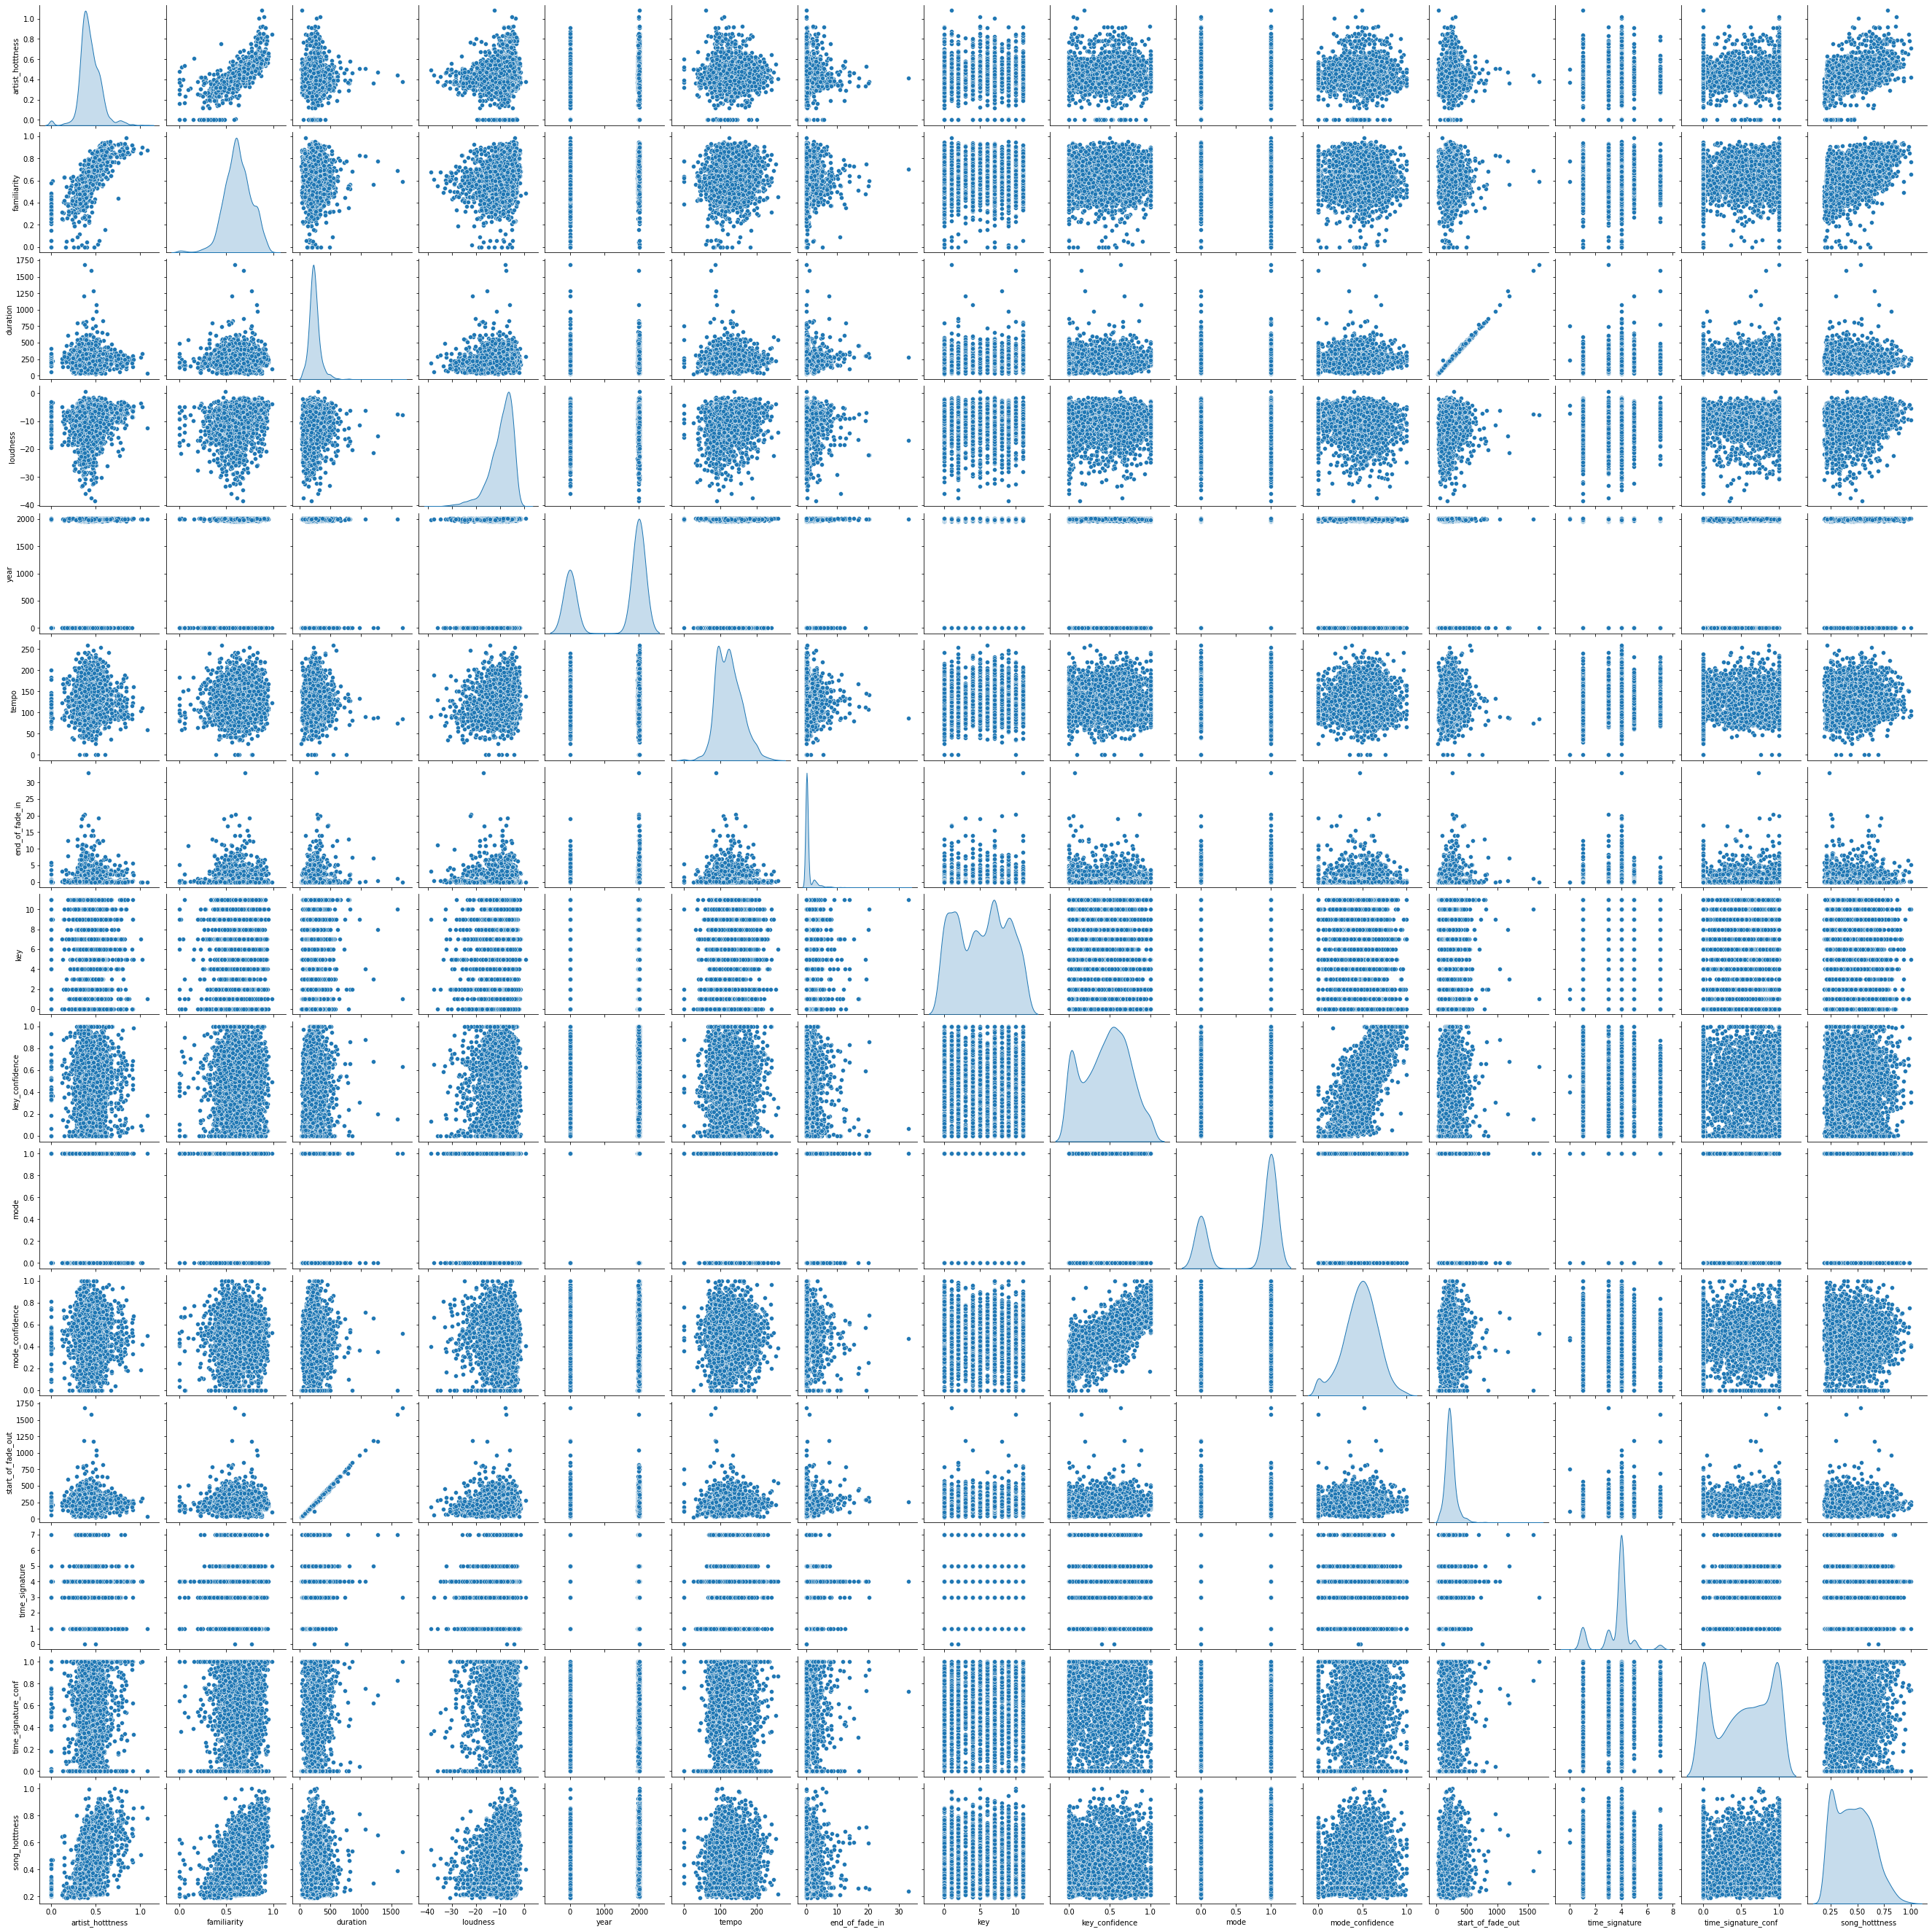

In [ ]:
feature_name = col_name[:-1]
sns.pairplot(train_dataset, diag_kind="kde")
plt.savefig('pairplot.png', dpi = 300) # 12take a bit to run

**Split labels from features**

In [ ]:

train_labels = train_dataset.pop(target)
test_labels = test_dataset.pop(target)

**Normalize training and test data**

In [ ]:
normed_train_data = train_dataset
normed_test_data = test_dataset
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Build a naive DNN model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07,
                                        amsgrad=False,
                                        name="Adam",)

  model.compile(loss = 'mse', optimizer = optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3840      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 135,681
Trainable params: 135,681
Non-trainable params: 0
_________________________________________________________________


**Train model**

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
model = build_model()
EPOCHS = 1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0440,  mae:0.1526,  mse:0.0440,  val_loss:0.0276,  val_mae:0.1341,  val_mse:0.0276,  
.............................

Text(0, 0.5, 'MAE song_hotttness')

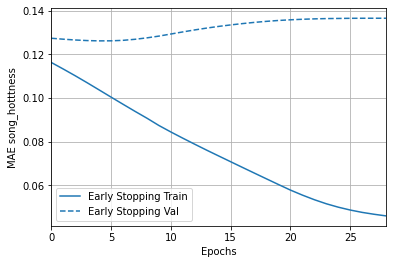

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
# plt.ylim([0, 10])
plt.ylabel('MAE'+target)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

27/27 - 0s - loss: 0.0277 - mae: 0.1343 - mse: 0.0277
Testing set Mean Abs Error:  0.13


**Make predictions and evaluation**

(0.15, 1.0)

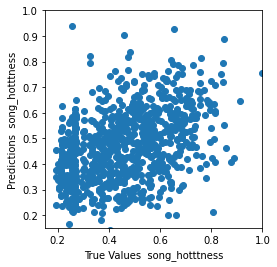

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values '+target)
plt.ylabel('Predictions '+ target)
plt.xlim([0.15, 1])
plt.ylim([0.15, 1])

# print('weighted vote --> %f' % np.mean(test_predictions), test_predictions, test_labels)

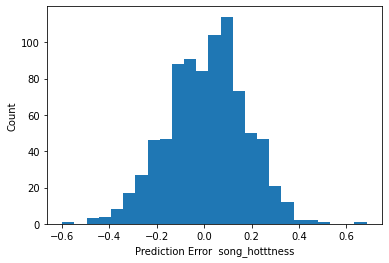

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error "+target)
_ = plt.ylabel("Count")
# plt.title('data augmentation = {}'.format(tl))